In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import os
import cv2

In [3]:
print(tf.__version__)

1.14.0


## Reading the data 

###### Auxiliary functions

In [4]:
class Bidict(dict):
    def __init__(self, *args, **kwargs):
        super(Bidict, self).__init__(*args, **kwargs)
        self.inverse = {}
        for key, value in self.items():
            self.inverse.setdefault(value,[]).append(key) 

    def __setitem__(self, key, value):
        if key in self:
            self.inverse[self[key]].remove(key) 
        super(Bidict, self).__setitem__(key, value)
        self.inverse.setdefault(value,[]).append(key)        

    def __delitem__(self, key):
        self.inverse.setdefault(self[key],[]).remove(key)
        if self[key] in self.inverse and not self.inverse[self[key]]: 
            del self.inverse[self[key]]
        super(Bidict, self).__delitem__(key)

In [5]:
def readCSV(path):
    #Read the csv file and transform it to a list
    list_csv = pd.read_csv(path, sep=';', header=None) 
    list_csv = list_csv.values.tolist()
    
    return list_csv

In [6]:
def getSamples(list_csv, name_to_label, annot_dict, nb_samples):
    ''' Return all the samples chosen as a list of tuples
        - list_csv:           List of all the row readed from the csv
        - name_to_label:      Dictionary whitch maps the gesture name to its annotation
        - annot_dict:         Dictionary whitch maps the annotations to its samples 
        - nb_samples:         List containing number of validation samples wanted for each class
        - samples:            List of all the samples represented by tuples chosen(dir_name, class)
    '''

    #Feed the annot_dict, each entry will consist of
    #a class number as a key and a list of tuples(dir_number, class)
    for i in range(len(list_csv)):
        idx = name_to_label[list_csv[i][1]]
        num = list_csv[i][0]
    
        annot_dict[idx].append((num, idx))
    
    #choice randomly nb_samples[i] of each category and concatenate 
    #all the samples in only one list
    samples = []
    for key, value in annot_dict.items():
        nums = random.choices(value, k=nb_samples[key])
        samples = samples + nums

    return samples

In [7]:
def createSamples(path_labels, path_train, path_validation, nb_samples_train, nb_samples_val, nb_samples_test):
    ''' Return the samples that will be used for training and testing
        - Path_labels:      Path to the labels csv file
        - Path_train:       Path to the train set csv file
        - Path_validation:  Path to the validation set file 
        
        * nb_samples:       Tuple containing in the first value the number of samples to be chosen 
                            for each class, excepts for the doing nothing category whitch the number
                            of samples to be chosen is represented in the second value of the tuple
                            
        - nb_samples_train: Number of samples for the training set
        - nb_samples_val:   Number of samples for the validation set
        - nb_samples_test:  Number of samples for the test set 
    '''
    
    labels = pd.read_csv(path_labels, sep=';', header=None)
    
    #create the name_to_label dict to map the class names to its annotations
    #create the train, validation and test annotation dicts
    name_to_label = {}
    validation_dict = {}
    train_dict = {}
    test_dict = {}
    for i in range(len(labels)):
        name_to_label[labels.values[i].tolist()[0]] = i
        train_dict[i] = []
        validation_dict[i] = []
        test_dict[i] = []
    
    #create a list of 27 values, where each value
    #corresponds to the number of samples to be chosen
    #randomly for that class
    nb_samples_t = [nb_samples_train[0]]*26 + [nb_samples_train[1]]
    nb_samples_v = [nb_samples_val[0]]*26 + [nb_samples_val[1]]
    nb_samples_tt = [nb_samples_test[0]]*26 + [nb_samples_test[1]]
    
    #split the train into train and test as the test csv do not provide annotations
    train_csv = readCSV(path_train)
    test_csv = train_csv[100000:]
    train_csv = train_csv[:100000]
    
    #Read the samples for each set
    train_samples = getSamples(train_csv, name_to_label, train_dict, nb_samples_t)
    validation_samples = getSamples(readCSV(path_validation), name_to_label, validation_dict, nb_samples_v)
    test_samples = getSamples(test_csv, name_to_label, test_dict, nb_samples_tt)
    
    vocab = Bidict(name_to_label)
    
    return train_samples, validation_samples, test_samples, vocab

In [8]:
def display_gesture(dir_path, samples, nb_samples, class_label):
    ini = class_label*nb_samples[0]
    if(class_label < 26):
        final = ini + nb_samples[0]
    else:
        final = ini + nb_samples[1]
    
    choice = random.choice(samples[ini:final])
    
    dir_path = os.path.join(dir_path, str(choice[0]))
    paths = os.listdir(dir_path)


    if(len(paths) > NB_FRAMES):
        offset = len(paths) - NB_FRAMES
        paths = paths[offset:]
    else:
        offset = NB_FRAMES - len(paths)
        for i in range(offset):
            paths.append(paths[-1])

    fig = plt.figure(figsize=(10,10))
    fig.suptitle(vocab.inverse[class_label], fontsize=20)
    for i, p in enumerate(paths):
        path = os.path.join(dir_path,p)
    
        frame = cv2.imread(path)
        frame = cv2.resize(frame, (IMG_ROWS, IMG_COLS), interpolation=cv2.INTER_AREA)
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        x = fig.add_subplot(6,5,i+1)
        x.imshow(frame_gray, cmap='gray')

In [20]:
nb_samples_train = (100, 300)
nb_samples_val = (10, 20)
nb_samples_test = (50,100)

IMG_ROWS = 64
IMG_COLS = 64
NB_FRAMES = 30
DATASET_PATH = '/media/cfcv/Daniel Alencar/jester/20bn-jester-v1'
NUM_CLASSES = 27

In [21]:
train_samples, val_samples, test_samples, vocab = createSamples(path_labels='CSV/jester-v1-labels.csv',
                                                         path_train='CSV/jester-v1-train.csv',
                                                         path_validation='CSV/jester-v1-validation.csv',
                                                         nb_samples_train=nb_samples_train,
                                                         nb_samples_val=nb_samples_val, 
                                                         nb_samples_test=nb_samples_test)
print('Train samples: ', len(train_samples))
print('Validation samples: ', len(val_samples))
print('Test samples: ', len(test_samples))

Train samples:  2900
Validation samples:  280
Test samples:  1400


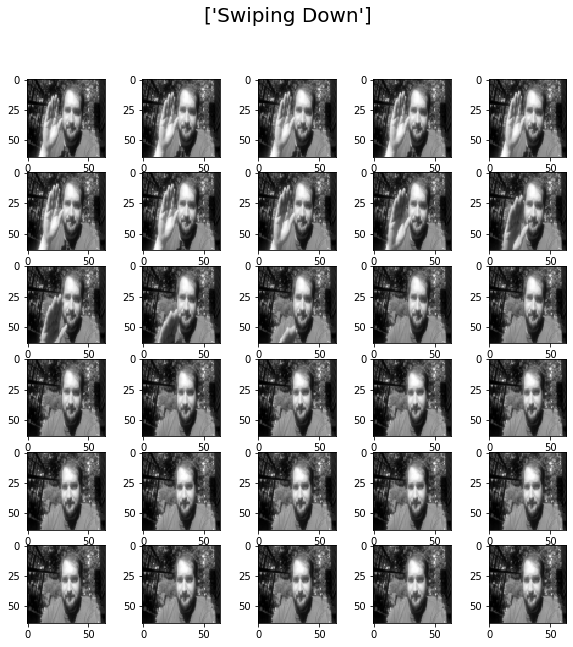

In [11]:
display_gesture(DATASET_PATH,train_samples, nb_samples_train, class_label=2)

In [12]:
def batch_generator(train_samples, batch_size, is_training):
    X = np.empty([batch_size, NB_FRAMES, IMG_ROWS, IMG_COLS, 1])
    Y = np.empty([batch_size, NUM_CLASSES])

    index_vector =list(range(len(train_samples)))
    current_example = 0
    new_epoch = False
    
    if(is_training):
        random.shuffle(index_vector)
        
    while(True):
        if(new_epoch and is_training):
            random.shuffle(index_vector)
            new_epoch = False
            current_example = 0
        
        annotations = []
        for i in range(batch_size):
            sample = train_samples[index_vector[current_example]]
            dir_number = sample[0]
            annotations.append(sample[1])
            
            dir_path = os.path.join(DATASET_PATH, str(dir_number))
            image_paths = os.listdir(dir_path)
            
            if(len(image_paths) > NB_FRAMES):
                offset = len(image_paths) - NB_FRAMES
                image_paths = image_paths[offset:]
            else:
                offset = NB_FRAMES - len(image_paths)
                for j in range(offset):
                    image_paths.append(image_paths[-1])
        
            for j, p in enumerate(image_paths):
                path = os.path.join(dir_path, p)
                
                frame = cv2.imread(path)
                frame = cv2.resize(frame, (IMG_ROWS, IMG_COLS), interpolation=cv2.INTER_AREA)
                frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                X[i, j, :, :, 0] = frame_gray
            
            current_example += 1
            if(current_example == len(train_samples)):
                new_epoch = True
                current_example = 0
        
        Y = tf.keras.utils.to_categorical(annotations, num_classes=NUM_CLASSES,dtype='float32')
        
        yield X, Y

In [18]:
def train(model, modelName, batch_size, val_batch_size, epochs, train_samples, valid_samples):
    checkPoint = tf.keras.callbacks.ModelCheckpoint(modelName, monitor='val_loss', save_best_only=True)
  
    it_per_epoch = np.ceil(len(train_samples) / batch_size)
    val_per_epoch = np.ceil(len(valid_samples) / val_batch_size)
  
    history = model.fit_generator(batch_generator(train_samples, batch_size, is_training=True), 
                                  steps_per_epoch=it_per_epoch,
                                  epochs=epochs,
                                  verbose=1,
                                  callbacks=[checkPoint],
                                  validation_data=batch_generator(valid_samples, batch_size=val_batch_size, is_training=False),
                                  validation_steps=val_per_epoch)
  
    return history

## Creating the model 

In [24]:
def Conv3d_BN(inputs, filters, kernel_size, strides, padding, activation, kernel_initialization='he_normal'):
    conv = tf.keras.layers.Conv3D(filters, kernel_size=kernel_size, strides=strides, padding=padding, 
                                  activation=activation, kernel_initializer=kernel_initialization)(inputs)
    bn = tf.keras.layers.BatchNormalization()(conv)
    
    return bn

In [38]:
def RL_Block(inputs, filters, kernel_size, strides, padding, activation, kernel_initialization='he_normal'):
    #input
    conv_bn = Conv3d_BN(inputs, filters, kernel_size=kernel_size, strides=strides, padding=padding, activation=None)
    conv_bn = tf.keras.layers.ReLU()(conv_bn)

    #conv -> batch -> relu
    conv_bn2 = Conv3d_BN(conv_bn, filters, kernel_size=kernel_size, strides=strides, padding=padding, activation=None)
    conv_bn2 = tf.keras.layers.ReLU()(conv_bn2)

    #conv -> batch_norm 
    conv_bn3 = Conv3d_BN(inputs, filters, kernel_size=kernel_size, strides=strides, padding=padding, activation=None)

    #branch1 + input -> ReLU
    final = keras.layers.Add()([conv_bn3, conv_bn])
    final = tf.keras.layers.ReLU()(final)
                         
    return final

In [14]:
def CNN3D_LSTM():
    inputs = tf.keras.Input(shape=(NB_FRAMES, IMG_ROWS, IMG_COLS, 1))
    
    conv_bn1 = Conv3d_BN(inputs, 16, kernel_size=(3,5,5), strides=1, padding='same', activation='relu')
    maxp1 = tf.keras.layers.MaxPool3D(pool_size=(2,2,2))(conv_bn1)
    
    conv_bn2 = Conv3d_BN(maxp1, 32, kernel_size=(3,3,3), strides=1, padding='same', activation='relu')
    maxp2 = tf.keras.layers.MaxPool3D(pool_size=(2,2,2))(conv_bn2)
    
    conv_bn3 = Conv3d_BN(maxp2, 64, kernel_size=(3,3,3), strides=1, padding='same', activation='relu')
    
    lstm1 = tf.keras.layers.ConvLSTM2D(32, (3,3), strides=(1,1),padding='same',
                      kernel_initializer='he_normal', recurrent_initializer='he_normal')(conv_bn3)
    
    lstm2 = tf.keras.layers.ConvLSTM2D(64, (3,3),strides=(1,1),padding='same',
                      kernel_initializer='he_normal', recurrent_initializer='he_normal')(lstm1)
    
    flatten = tf.keras.layers.Flatten()(lstm2)
    
    d1 = tf.keras.layers.Dense(256, activation='relu')(flatten)
    d2 = tf.keras.layers.Dropout(0.2)(d1)
    
    out = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(d2)

    model = tf.keras.Model(inputs=inputs, outputs=out)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='categorical_crossentropy', metrics = ['accuracy'])
    
    return model

In [ ]:
def Deep_CNN3D_LSTM():
    inputs = tf.keras.Input(shape=(NB_FRAMES, IMG_ROWS, IMG_COLS, 1))
    
    conv_bn1 = Conv3d_BN(inputs, 16, kernel_size=(3,5,5), strides=1, padding='same', activation='relu')
    conv_bn2 = Conv3d_BN(conv_bn1, 16, kernel_size=(3,5,5), strides=1, padding='same', activation='relu')
    maxp1 = tf.keras.layers.MaxPool3D(pool_size=(2,2,2))(conv_bn2)
    
    conv_bn3 = Conv3d_BN(maxp1, 32, kernel_size=(3,3,3), strides=1, padding='same', activation='relu')
    conv_bn4 = Conv3d_BN(conv_bn3, 32, kernel_size=(3,3,3), strides=1, padding='same', activation='relu')
    conv_bn5 = Conv3d_BN(conv_bn4, 32, kernel_size=(3,3,3), strides=1, padding='same', activation='relu')
    maxp2 = tf.keras.layers.MaxPool3D(pool_size=(2,2,2))(conv_bn5)
    
    conv_bn6 = Conv3d_BN(maxp2, 64, kernel_size=(3,3,3), strides=1, padding='same', activation='relu')
    conv_bn7 = Conv3d_BN(conv_bn6, 64, kernel_size=(3,3,3), strides=1, padding='same', activation='relu')
    
    lstm1 = tf.keras.layers.ConvLSTM2D(32, (3,3), strides=(1,1),padding='same',
                      kernel_initializer='he_normal', recurrent_initializer='he_normal')(conv_bn3)
    
    lstm2 = tf.keras.layers.ConvLSTM2D(64, (3,3),strides=(1,1),padding='same',
                      kernel_initializer='he_normal', recurrent_initializer='he_normal')(lstm1)
    
    flatten = tf.keras.layers.Flatten()(lstm2)
    
    d1 = tf.keras.layers.Dense(512, activation='relu')(flatten)
    drop1 = tf.keras.layers.Dropout(0.2)(d1)
    
    d2 = tf.keras.layers.Dense(128, activation='relu')(drop1)
    drop2 = tf.keras.layers.Dropout(0.2)(d2)
    
    out = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(drop2)

    model = tf.keras.Model(inputs=inputs, outputs=out)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='categorical_crossentropy', metrics = ['accuracy'])
    
    return model

In [39]:
 def ResNEt_CNN3D_LSTM():
    inputs = tf.keras.Input(shape=(NB_FRAMES, IMG_ROWS, IMG_COLS, 1))
    
    rl1 = RL_Block(inputs, 16, kernel_size=(3,5,5), strides=1, padding='same', activation='relu')
    maxp1 = tf.keras.layers.MaxPool3D(pool_size=(2,2,2))(rl1)
    
    rl2 = RL_Block(maxp1, 32, kernel_size=(3,3,3), strides=1, padding='same', activation='relu')
    maxp2 = tf.keras.layers.MaxPool3D(pool_size=(2,2,2))(rl2)
    
    rl3 = RL_Block(maxp2, 64, kernel_size=(3,3,3), strides=1, padding='same', activation='relu')
    rl4 = RL_Block(rl3, 64, kernel_size=(3,3,3), strides=1, padding='same', activation='relu')
    
    lstm1 = tf.keras.layers.ConvLSTM2D(32, (3,3), strides=(1,1),padding='same',
                      kernel_initializer='he_normal', recurrent_initializer='he_normal')(rl4)
    
    lstm2 = tf.keras.layers.ConvLSTM2D(64, (3,3),strides=(1,1),padding='same',
                      kernel_initializer='he_normal', recurrent_initializer='he_normal')(lstm1)
    
    flatten = tf.keras.layers.Flatten()(lstm2)
    
    d1 = tf.keras.layers.Dense(512, activation='relu')(flatten)
    drop1 = tf.keras.layers.Dropout(0.2)(d1)
    
    d2 = tf.keras.layers.Dense(128, activation='relu')(drop1)
    drop2 = tf.keras.layers.Dropout(0.2)(d2)
    
    out = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(drop2)

    model = tf.keras.Model(inputs=inputs, outputs=out)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
model = CNN3D_LSTM()

## Training 

In [ ]:
train(model, 'test.h5', 10, 10, 4, train_samples, val_samples)

## Testing 